In [13]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from skimage.io import imsave
import imageio
from skimage import data, color
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
from random import sample
import zipfile
from torchvision import datasets, transforms
from scipy.ndimage import rotate, gaussian_filter

# Generar Fondos

In [14]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

sklearn_and_custom_images = []
cifar_images = []

FACES_IMAGES = 12833
RATIO = 12  # Proporción de imágenes que queremos generar respecto a las originales 
TOTAL_IMAGES = FACES_IMAGES * RATIO # Número total de imágenes que queremos generar

for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    sklearn_and_custom_images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
pictures_folder_path = 'pictures'
if not os.path.exists(pictures_folder_path):
    with zipfile.ZipFile('Pictures.zip', 'r') as zip_ref:
        zip_ref.extractall(pictures_folder_path)

for i in range(31):
    filename = f'{pictures_folder_path}/{str(i)}.jpg'
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    sklearn_and_custom_images.append(resize(img, (100,100)))

# Imágenes de CIFAR-10
cifar_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
])

cifar_ds = datasets.CIFAR10(root='./data', train=True, download=True)

safe_labels = {0,1,2,3,4,5,6,7,8,9} #0:avion, 1: automovil, 2:pajaro, 3: gato, 4: ciervo, 5: perro, 6: rana, 7: caballo, 8: camion, 9: barco

print("Obteniendo imágenes de CIFAR-10 …")
for img_pil, lbl in tqdm(cifar_ds, total=len(cifar_ds)):
    if lbl not in safe_labels:
        continue
    img_np = np.array(cifar_tf(img_pil)).astype(np.float64)
    cifar_images.append(img_np)

print(f"Se agregaron {len(cifar_images)} imágenes de CIFAR-10")

Files already downloaded and verified
Obteniendo imágenes de CIFAR-10 …


100%|██████████| 50000/50000 [00:02<00:00, 18748.94it/s]

Se agregaron 50000 imágenes de CIFAR-10


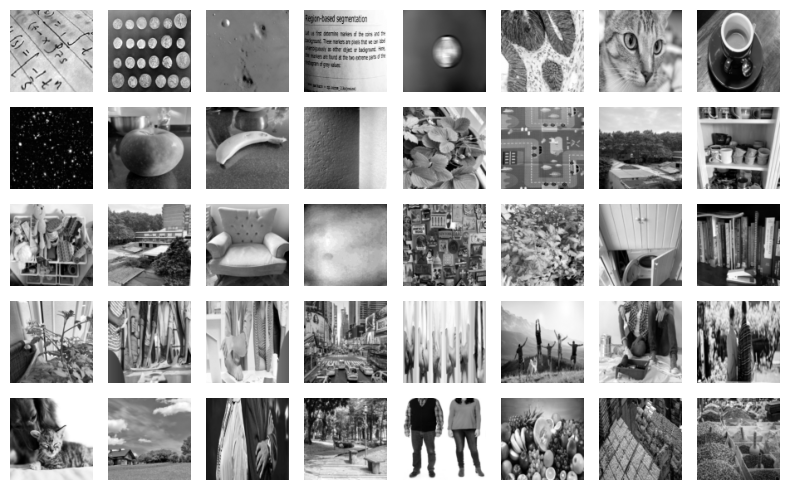

In [15]:
# Visualización
fig, ax = plt.subplots(5, 8, figsize=(8, 5), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(40):
    axes[i].imshow(sklearn_and_custom_images[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()

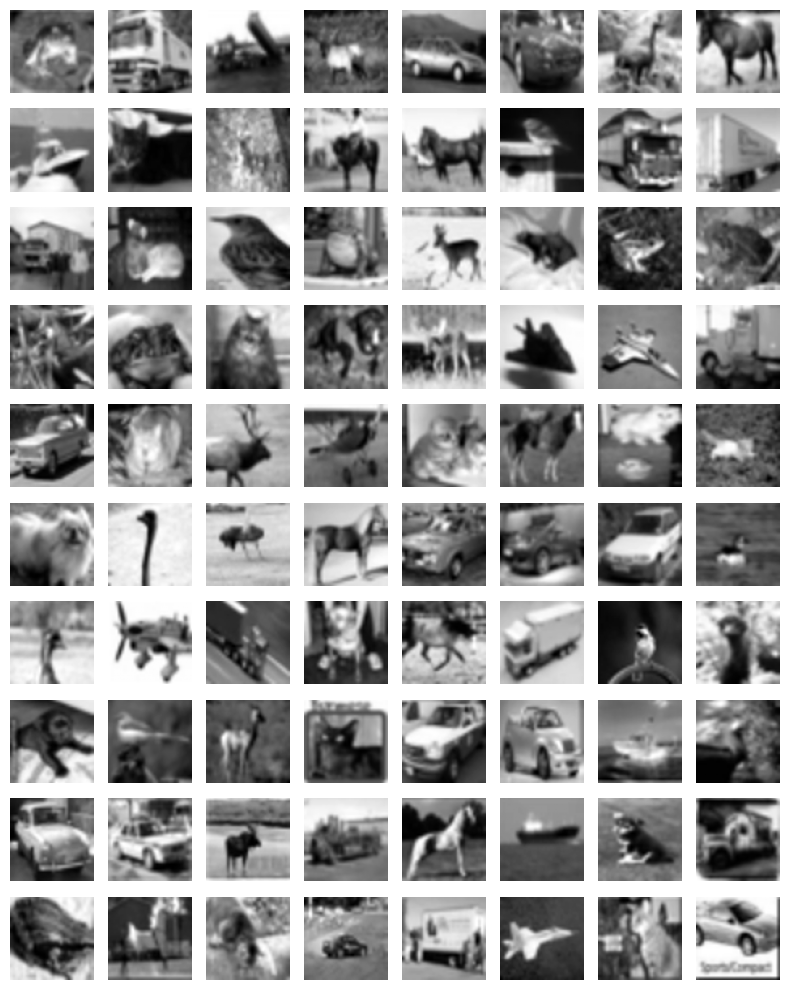

In [16]:
# Visualización
fig, ax = plt.subplots(10, 8, figsize=(8, 10), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(80):
    axes[i].imshow(cifar_images[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()

In [17]:
# Tamaño de las imágenes de rostros
size = (64, 64)
print(f'Image size: {size}')

Image size: (64, 64)


In [18]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Fix: converimos float [0,1] a uint8 [0,255]
    patches = (patches * 255).astype(np.uint8)

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [19]:
def generate_augmented_backgrounds(images, target_count):
    """
    Genera fondos augmentados combinando rotaciones y blur
    
    Args:
        images: Lista de imágenes originales
        target_count: Número total de imágenes que necesitas
    
    Returns:
        np.array con exactamente target_count imágenes
    """
    augmented = []
    
    # 1. Agregar imágenes originales
    for img in images:
        if img.dtype != np.uint8:
            # Normalize to 0-255 if needed
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)
        augmented.append(img)
    print(f"Imágenes originales: {len(images)}")
    
    if len(augmented) >= target_count:
        return np.array(augmented[:target_count])
    
    # 2. Aplicar rotaciones
    rotation_angles = [90, 180, 270, 45, 135, 225, 315]
    
    print("Aplicando rotaciones...")
    for angle in tqdm(rotation_angles, desc="Rotaciones"):
        for img in images:
            if len(augmented) >= target_count:
                break
            rotated = rotate(img, angle, reshape=False, mode='reflect')
            if rotated.dtype != np.uint8:
                # Normalize to 0-255 if needed
                if rotated.max() <= 1.0:
                    rotated = (rotated * 255).astype(np.uint8)
                else:
                    rotated = rotated.astype(np.uint8)
            augmented.append(rotated)
        if len(augmented) >= target_count:
            break
    
    print(f"Después de rotaciones: {len(augmented)}")
    
    if len(augmented) >= target_count:
        return np.array(augmented[:target_count])
    
    # 3. Aplicar blur a imágenes originales
    blur_sigmas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    
    print("Aplicando blur...")
    for sigma in tqdm(blur_sigmas, desc="Blur levels"):
        for img in images:
            if len(augmented) >= target_count:
                break
            blurred = gaussian_filter(img, sigma=sigma)
            if blurred.dtype != np.uint8:
                # Normalize to 0-255 if needed
                if blurred.max() <= 1.0:
                    blurred = (blurred * 255).astype(np.uint8)
                else:
                    blurred = blurred.astype(np.uint8)
            augmented.append(blurred)
        if len(augmented) >= target_count:
            break
    
    print(f"Después de blur: {len(augmented)}")
    
    if len(augmented) >= target_count:
        return np.array(augmented[:target_count])
    
    # 4. Si aún necesitas más, combinar rotaciones + blur
    print("Aplicando rotaciones + blur...")
    rotation_blur_combinations = [
        (90, 1.0), (180, 1.0), (270, 1.0),
        (45, 1.5), (135, 1.5), (225, 1.5), (315, 1.5),
        (90, 2.0), (180, 2.0), (270, 2.0)
    ]
    
    for angle, sigma in tqdm(rotation_blur_combinations, desc="Rotación + Blur"):
        for img in images:
            if len(augmented) >= target_count:
                break
            # Primero rotar, luego aplicar blur
            rotated = rotate(img, angle, reshape=False, mode='reflect')
            rotated_blurred = gaussian_filter(rotated, sigma=sigma)
            #rotated_blurred = np.clip(rotated_blurred, 0, 255)
            if rotated_blurred.dtype != np.uint8:
                # Normalize to 0-255 if needed
                if rotated_blurred.max() <= 1.0:
                    rotated_blurred = (rotated_blurred * 255).astype(np.uint8)
                else:
                    rotated_blurred = rotated_blurred.astype(np.uint8)
            augmented.append(rotated_blurred)
        if len(augmented) >= target_count:
            break
    
    print(f"Total final: {len(augmented)}")
    
    # Asegurar que tenemos exactamente target_count
    return np.array(augmented[:target_count])

In [20]:
# Extraemos las imágenes de fondo de sklearn y las imágenes personalizadas
negative_patches_sklearn = np.vstack([extract_patches(im, 64, scale) for im in tqdm(sklearn_and_custom_images, desc='Procesando sklearn/custom') for scale in [0.1,0.25,0.5,0.75,1]])

print(f'{negative_patches_sklearn.dtype=}, {negative_patches_sklearn.min()=}, {negative_patches_sklearn.max()=}')
print(len(negative_patches_sklearn))

Procesando sklearn/custom: 100%|██████████| 40/40 [00:01<00:00, 27.87it/s]

negative_patches_sklearn.dtype=dtype('uint8'), negative_patches_sklearn.min()=0, negative_patches_sklearn.max()=255
12800


In [21]:
# Generamos parches de fondo rotados a partir de las imágenes de CIFAR-10
patches_needed_from_cifar = TOTAL_IMAGES - len(negative_patches_sklearn)
print(f'Fondos extra que se necesitan: {patches_needed_from_cifar}')

cifar_patches = np.array(generate_augmented_backgrounds(cifar_images, patches_needed_from_cifar))

print(f'{cifar_patches.dtype=}, {cifar_patches.min()=}, {cifar_patches.max()=}')

Fondos extra que se necesitan: 141196
Imágenes originales: 50000
Aplicando rotaciones...


Rotaciones:  14%|█▍        | 1/7 [00:38<03:48, 38.09s/it]


Después de rotaciones: 141196
cifar_patches.dtype=dtype('uint8'), cifar_patches.min()=0, cifar_patches.max()=255


In [22]:
# Combinar todos los patches
negative_patches = np.vstack([negative_patches_sklearn, cifar_patches])

print(f'{negative_patches.dtype=}, {negative_patches.min()=}, {negative_patches.max()=}')

print(f'Número de parches negativos: {len(negative_patches)}')
print(f'Número de parches requeridos: {TOTAL_IMAGES}')

negative_patches.dtype=dtype('uint8'), negative_patches.min()=0, negative_patches.max()=255
Número de parches negativos: 153996
Número de parches requeridos: 153996


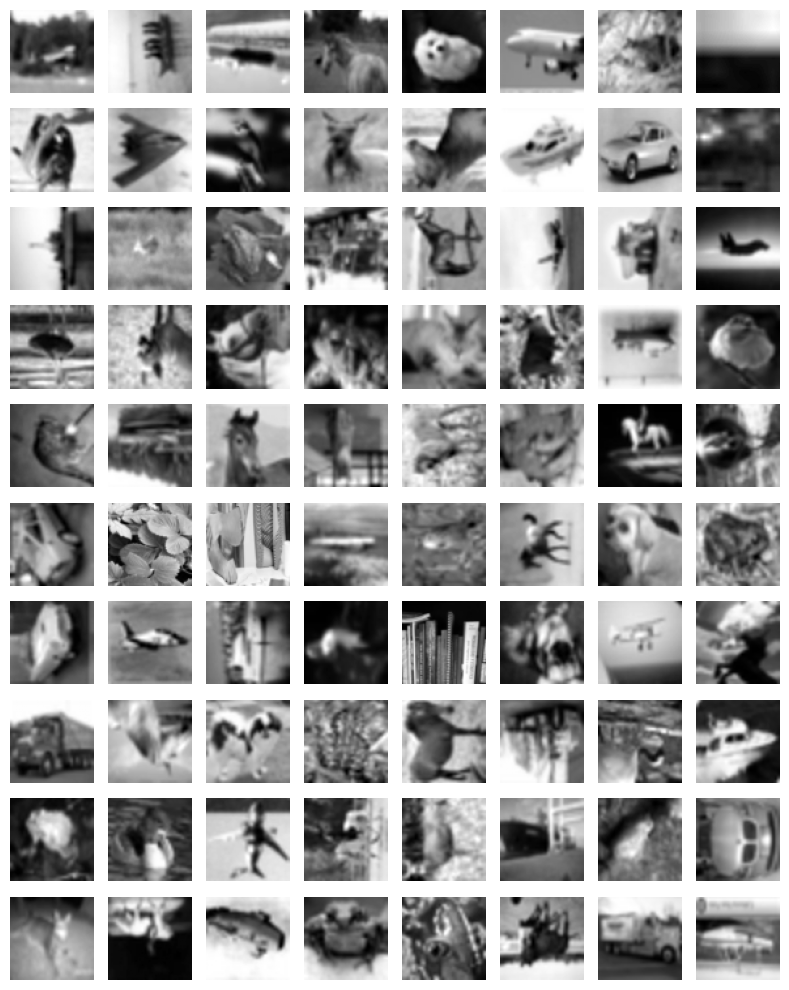

In [23]:
# Visualizamos una muestra
samples = sample(range(negative_patches.shape[0]), 80)
fig, ax = plt.subplots(10, 8, figsize=(8, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [24]:
def save_patches(patches, output_dir='../content', zip_filename = f'Backgrounds_x{RATIO}_v1.zip'):
    """
    Save patches as individual .pgm files compressed into a zip file.
    
    Args:
        patches (np.ndarray): Array of patches to save
        output_dir (str): Directory to save the .zip file
    """

    patches_folder_path = 'patches'
    prefix='background'

    # Create output directory if it doesn't exist
    os.makedirs(patches_folder_path, exist_ok=True)

    # If there's an existing zip file, remove it
    zip_filepath = os.path.join(output_dir, zip_filename)
    if os.path.exists(zip_filepath):
        os.remove(zip_filepath)
    
    saved_files = []
    for i, patch in enumerate(tqdm(patches, desc='Saving patches')):
        # Create filename
        filename = f"{prefix}_{i:06d}.pgm"
        file_path = os.path.join(patches_folder_path, filename)

        # Save as .pgm file using imageio
        imageio.imwrite(file_path, patch)

         # Add to list of saved files
        saved_files.append(file_path)
    
    print(f"Saving {len(patches)} patches as .pgm files...")
   
    # Create zip file with all the .pgm files
    zip_filepath = os.path.join(output_dir, zip_filename)

    print(f"\nCompressing {len(saved_files)} .pgm files into {zip_filename}...")
    with zipfile.ZipFile(zip_filepath, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in tqdm(saved_files, desc='Compressing files'):
            # Add file to zip with just the filename (not the full path)
            arcname = os.path.basename(file_path)
            zipf.write(file_path, arcname)
    
    print(f"\nZip file created: {zip_filepath}")
    
    print("Cleaning up temporary files...")
    for file_path in saved_files:
        os.remove(file_path)

save_patches(negative_patches)

Saving patches: 100%|██████████| 153996/153996 [01:09<00:00, 2211.42it/s]


Saving 153996 patches as .pgm files...

Compressing 153996 .pgm files into Backgrounds_x12_v1.zip...


Compressing files: 100%|██████████| 153996/153996 [00:39<00:00, 3888.08it/s]



Zip file created: ../content/Backgrounds_x12_v1.zip
Cleaning up temporary files...
